##  圖像對準 Feature-Based Image alignment
Feature Matching + Homography to find Objects<br>
https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

使用<br>

* cv2.FlannBasedMatcher 使用FLANN找到特徵匹配
* cv2.findHomography 到兩平面間的透視變換 https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780
* cv2.perspectiveTransform 執行兩向量間的透視變換 
* cv2.getPerspectiveTransform
* cv2.warpPerspective

### 載入標準標靶圖檔和想要校正的標靶圖檔

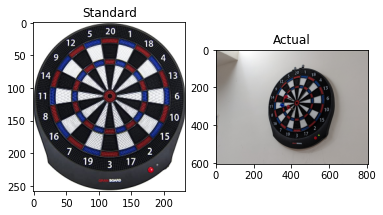

In [57]:
import cv2 
import numpy as np 
from matplotlib import pyplot as plt
%matplotlib inline

# load standard dartboard image 
dartboard_std = cv2.imread("data/dartboard.jpg")
dartboard_std = cv2.resize(dartboard_std, dsize=(int(dartboard_std.shape[1]/2), int(dartboard_std.shape[0]/2)))
dartboard_std = cv2.cvtColor(dartboard_std, cv2.COLOR_BGR2RGB)

# load actual dartboard image to be alignmented
dartboard_align = cv2.imread("data/dartboard_actual.jpg")
dartboard_align = cv2.resize(dartboard_align, dsize=(int(dartboard_align.shape[1]/5), int(dartboard_align.shape[0]/5)))
dartboard_align = cv2.cvtColor(dartboard_align, cv2.COLOR_BGR2RGB)

plt.subplot(121)
plt.title("Standard")
plt.imshow(dartboard_std)
plt.subplot(122)
plt.title("Actual")
plt.imshow(dartboard_align)


###  找關鍵點和描述子 Find keypoints and descriptorsFind keypoints and descriptors
* cv2.sift_create()
* sift.detectAndCompute()
* cv2.FlannBasedMatcher()
* flann_matcher.knnMatch()

In [58]:
# 使用sift搜尋特徵點和描述子 
'''
 - cv2.SIFT()
 - SIFT.detectAncCompute()
'''
MAX_NUM_FEARTURES = 1000
sift_detector = cv2.SIFT_create(MAX_NUM_FEARTURES)
keypoint1, descriptor1 = sift_detector.detectAndCompute(dartboard_std, None)
keypoint2, descriptor2 = sift_detector.detectAndCompute(dartboard_align, None)

# 使用FLANN 特徵匹配演算法 
# 設定FLANN參數
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

# 使用FLANN matcher尋找匹配
flann_matcher = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann_matcher.knnMatch(descriptor1,descriptor2,k=2)

# store all the good matches as per Lowe's ratio test.
good_matches = []
for m,n in matches:
    if m.distance < 0.7*n.distance: # m,n前2與原圖間歐式距離最相近的匹配點, 若m/n小於一定比率,則m匹配的越準確
        good_matches.append(m)

print("good_matches size:", len(good_matches))

good_matches size: 53


###  找到 Homography Maxtrix 轉換矩陣得到透視轉換關係
* cv2.findHomography
* cv2.perspectiveTransform
* cv2.getPerspectiveTransform
* cv2.warpPerspective

In [59]:
MIN_MATCH_COUNT = 10
if len(good_matches)>MIN_MATCH_COUNT:
    # 整理匹配點座標
    src_pts = np.float32([ keypoint1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)    # 原圖關鍵點座標
    dst_pts = np.float32([ keypoint2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)    # 目標圖關鍵點座標
    print("src_pts's shape:", src_pts.shape)
    '''
    m 的型別為DMatch
    DMatch.queryIdx 指的是原圖關鍵點在keypoint1中的index
    DMatch.trainIdx 指的是目標圖圖關鍵點在keypoint2中的index
    https://stackoverflow.com/questions/13318853/opencv-drawmatches-queryidx-and-trainidx
    '''

    # 找出透視轉換矩陣
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) # M: homography matrix
    matchesMask = mask.ravel().tolist()
    # 找出透視轉換四個角點
    h,w,_ = dartboard_std.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    dartboard_align = cv2.polylines(dartboard_align,[np.int32(dst)],True,255,3, cv2.LINE_AA)

    # 裁切目標區域並將目標圖校準
    M = cv2.getPerspectiveTransform(dst,pts)
    dartboard_aligned = cv2.warpPerspective(dartboard_align, M, (h,w))
else:
    print( "Not enough matches are found - {}/{}".format(len(good_matches), MIN_MATCH_COUNT) )
    matchesMask = None

src_pts's shape: (53, 1, 2)


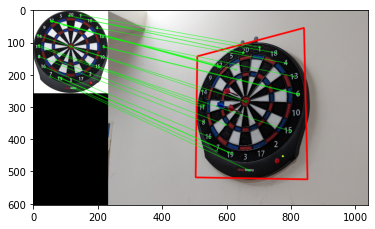

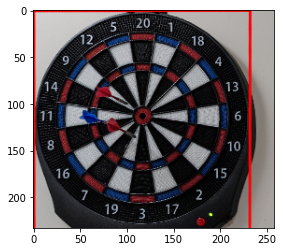

In [60]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv2.drawMatches(dartboard_std, keypoint1, dartboard_align, keypoint2, good_matches, None, **draw_params)
plt.imshow(img3, 'gray'),plt.show()
plt.imshow(dartboard_aligned)

##  Reference
Feature Matching + Homography to find Objects<br>
https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html<br>
OpenCv-C++-FLANN特徵匹配演算法 (快於 Matcher)<br>
https://www.itread01.com/content/1545506107.html <br>
https://docs.opencv.org/3.4/d5/d6f/tutorial_feature_flann_matcher.html <br>
歐式距離匹配<br>
https://firefox2100.github.io/p.e.m.p.w.s2020/02/16/SIFT(4)/<br>
Geometric Transformations of Images<br>
https://docs.opencv.org/4.x/da/d6e/tutorial_py_geometric_transformations.html<br>
